# Feature Engineering and Data Transformation

This notebook performs feature engineering and data transformation for both e-commerce and credit card fraud datasets.

## Objectives
1. Feature Engineering for Fraud_Data.csv:
   - Transaction frequency and velocity features
   - Time-based features (hour_of_day, day_of_week, time_since_signup)
2. Data Transformation:
   - Normalize/scale numerical features
   - Encode categorical features
3. Handle Class Imbalance:
   - Apply SMOTE or undersampling to training data only
   - Document class distribution before and after resampling


In [27]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import ipaddress
from pathlib import Path
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

warnings.filterwarnings('ignore')

# Set up paths - ensure we're working from the project root
project_root = Path().resolve()
if project_root.name == 'notebooks':
    project_root = project_root.parent
elif (project_root / 'notebooks').exists():
    pass  # Already at project root
else:
    # Try to find project root by looking for data directory
    current = Path().resolve()
    while current != current.parent:
        if (current / 'data').exists():
            project_root = current
            break
        current = current.parent

DATA_DIR = project_root / 'data' / 'raw'
PROCESSED_DIR = project_root / 'data' / 'processed'
OUTPUT_DIR = project_root / 'outputs' / 'eda' / 'feature-engineering'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)  # Ensure output directory exists
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)  # Ensure processed directory exists

# Print relative paths so output is the same for all team members
print(f"Project root: .")
print(f"Data directory: {DATA_DIR.relative_to(project_root)}")
print(f"Processed directory: {PROCESSED_DIR.relative_to(project_root)}")
print(f"Output directory: {OUTPUT_DIR.relative_to(project_root)}")
print(f"Data directory exists: {DATA_DIR.exists()}")

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Helper function to save plots (prints relative path for portability)
def save_plot(fig, filename, dpi=300, bbox_inches='tight'):
    """Save plot to output directory"""
    filepath = OUTPUT_DIR / filename
    fig.savefig(filepath, dpi=dpi, bbox_inches=bbox_inches)
    rel = filepath.relative_to(project_root)
    print(f"Plot saved to: {rel}")

print("Libraries imported successfully!")


Project root: .
Data directory: data\raw
Processed directory: data\processed
Output directory: outputs\eda\feature-engineering
Data directory exists: True
Libraries imported successfully!


## Part 1: E-commerce Fraud Data Feature Engineering


In [28]:
# Load the cleaned fraud data (assuming EDA notebook has been run)
# If running independently, load and clean data here
fraud_df = pd.read_csv(DATA_DIR / 'Fraud_Data.csv')

# Convert timestamps
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

# Load IP country mapping if needed
ip_country_df = pd.read_csv(DATA_DIR / 'IpAddress_to_Country.csv')

print(f"Fraud Data Shape: {fraud_df.shape}")
print(f"Columns: {fraud_df.columns.tolist()}")
fraud_df.head()


Fraud Data Shape: (151112, 11)
Columns: ['user_id', 'signup_time', 'purchase_time', 'purchase_value', 'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class']


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


### 1.1 Time-based Features


In [29]:
# Extract hour of day from purchase_time
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour

# Extract day of week (0=Monday, 6=Sunday)
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek

# Calculate time since signup (in hours)
fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds() / 3600

# Handle negative time_since_signup (purchase before signup - data error)
fraud_df['time_since_signup'] = fraud_df['time_since_signup'].clip(lower=0)

print("Time-based features created:")
print(fraud_df[['purchase_time', 'signup_time', 'hour_of_day', 'day_of_week', 'time_since_signup']].head(10))

# Summary statistics
print("\nTime-based Features Summary:")
print(fraud_df[['hour_of_day', 'day_of_week', 'time_since_signup']].describe())


Time-based features created:
        purchase_time         signup_time  hour_of_day  day_of_week  \
0 2015-04-18 02:47:11 2015-02-24 22:55:49            2            5   
1 2015-06-08 01:38:54 2015-06-07 20:39:50            1            0   
2 2015-01-01 18:52:45 2015-01-01 18:52:44           18            3   
3 2015-05-04 13:54:50 2015-04-28 21:13:25           13            0   
4 2015-09-09 18:40:53 2015-07-21 07:09:52           18            2   
5 2015-07-09 08:05:14 2015-05-21 06:03:03            8            3   
6 2015-08-27 03:37:57 2015-08-01 22:40:52            3            3   
7 2015-05-25 17:21:14 2015-04-06 07:35:45           17            0   
8 2015-06-02 14:01:54 2015-04-21 23:38:34           14            1   
9 2015-03-23 23:05:42 2015-01-25 17:49:49           23            0   

   time_since_signup  
0        1251.856111  
1           4.984444  
2           0.000278  
3         136.690278  
4        1211.516944  
5        1178.036389  
6         604.951389  
7    

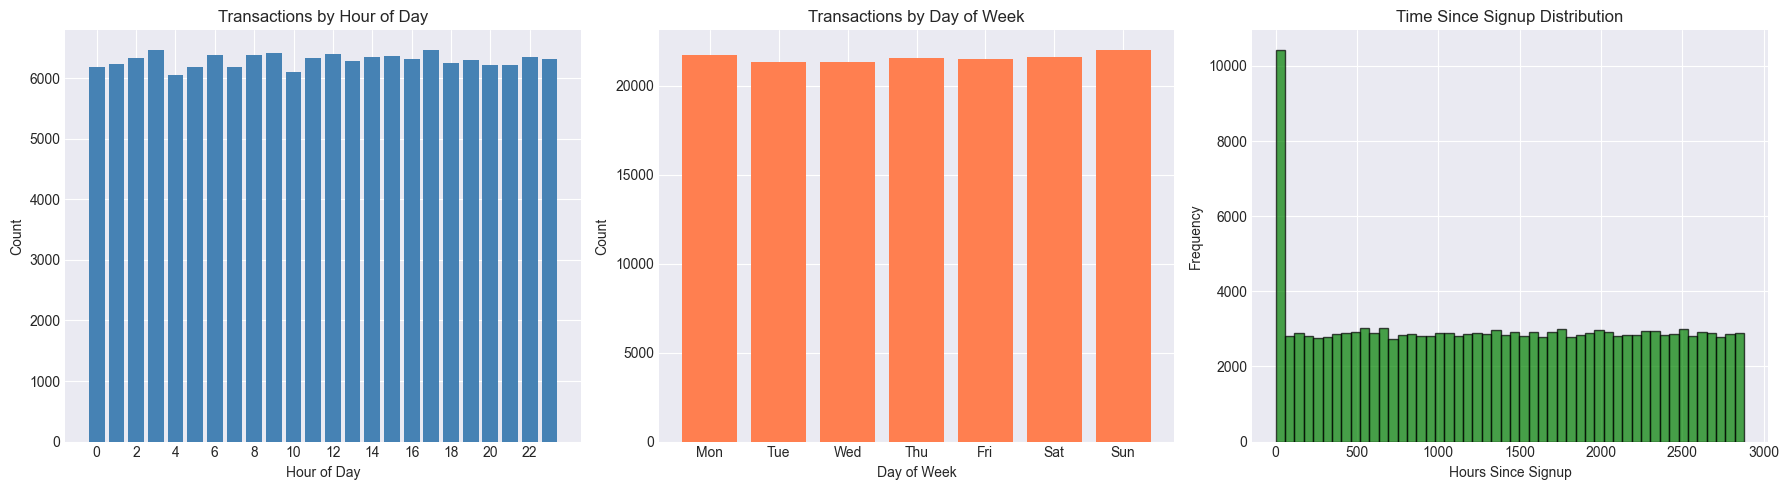

In [30]:
# Visualize time-based features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Hour of day distribution
hour_counts = fraud_df['hour_of_day'].value_counts().sort_index()
axes[0].bar(hour_counts.index, hour_counts.values, color='steelblue')
axes[0].set_title('Transactions by Hour of Day')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Count')
axes[0].set_xticks(range(0, 24, 2))

# Day of week distribution
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
day_counts = fraud_df['day_of_week'].value_counts().sort_index()
axes[1].bar(day_counts.index, day_counts.values, color='coral')
axes[1].set_title('Transactions by Day of Week')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Count')
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(day_names)

# Time since signup distribution
axes[2].hist(fraud_df['time_since_signup'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[2].set_title('Time Since Signup Distribution')
axes[2].set_xlabel('Hours Since Signup')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


### 1.2 Transaction Frequency and Velocity Features


In [31]:
# Sort by user_id and purchase_time for proper calculation
fraud_df = fraud_df.sort_values(['user_id', 'purchase_time']).reset_index(drop=True)

# Calculate transaction frequency per user (total count)
user_transaction_count = fraud_df.groupby('user_id').size().reset_index(name='total_transactions')
fraud_df = fraud_df.merge(user_transaction_count, on='user_id', how='left')

# OPTIMIZED: Calculate transaction frequency in time windows using vectorized operations
# This uses merge_asof and groupby for much better performance
print("Calculating transaction frequency features (optimized version)...")

# Convert purchase_time to numeric for faster comparisons (seconds since epoch)
fraud_df['purchase_time_sec'] = (fraud_df['purchase_time'] - pd.Timestamp('1970-01-01')).dt.total_seconds()

# Initialize columns
fraud_df['transactions_last_24h'] = 0
fraud_df['transactions_last_7d'] = 0
fraud_df['transactions_last_30d'] = 0

# Use groupby and vectorized operations - much faster!
def calculate_window_counts(group):
    """Calculate rolling window counts for a user group"""
    times = group['purchase_time_sec'].values
    n = len(times)
    counts_24h = []
    counts_7d = []
    counts_30d = []
    
    # Vectorized calculation using numpy broadcasting
    for i in range(n):
        current_time = times[i]
        time_diffs = current_time - times[:i+1]  # Only look at past transactions
        
        counts_24h.append(np.sum(time_diffs <= 24*3600))  # 24 hours in seconds
        counts_7d.append(np.sum(time_diffs <= 7*24*3600))  # 7 days in seconds
        counts_30d.append(np.sum(time_diffs <= 30*24*3600))  # 30 days in seconds
    
    group['transactions_last_24h'] = counts_24h
    group['transactions_last_7d'] = counts_7d
    group['transactions_last_30d'] = counts_30d
    return group

# Apply to each user group
fraud_df = fraud_df.groupby('user_id', group_keys=False).apply(calculate_window_counts)

# Drop temporary column
fraud_df = fraud_df.drop('purchase_time_sec', axis=1)

print("✓ Transaction frequency features created!")
print(fraud_df[['user_id', 'purchase_time', 'total_transactions', 
                'transactions_last_24h', 'transactions_last_7d', 'transactions_last_30d']].head(10))


Calculating transaction frequency features (optimized version)...
✓ Transaction frequency features created!
   user_id       purchase_time  total_transactions  transactions_last_24h  \
0        2 2015-02-21 10:03:37                   1                      1   
1        4 2015-09-26 21:32:16                   1                      1   
2        8 2015-08-13 11:53:07                   1                      1   
3        9 2015-05-20 23:06:42                   1                      1   
4       12 2015-03-04 20:56:37                   1                      1   
5       16 2015-03-12 12:46:23                   1                      1   
6       18 2015-10-23 00:18:57                   1                      1   
7       26 2015-03-21 09:04:08                   1                      1   
8       33 2015-10-28 18:12:41                   1                      1   
9       39 2015-01-08 18:13:26                   1                      1   

   transactions_last_7d  transactions_last_3

In [32]:
# Calculate transaction velocity (transactions per hour in last 24h)
fraud_df['velocity_last_24h'] = fraud_df['transactions_last_24h'] / 24.0

# Calculate average purchase value per user
user_avg_purchase = fraud_df.groupby('user_id')['purchase_value'].mean().reset_index(name='avg_purchase_value')
fraud_df = fraud_df.merge(user_avg_purchase, on='user_id', how='left')

# Calculate deviation from average purchase value
fraud_df['purchase_value_deviation'] = fraud_df['purchase_value'] - fraud_df['avg_purchase_value']

print("Velocity and deviation features created:")
print(fraud_df[['user_id', 'velocity_last_24h', 'avg_purchase_value', 'purchase_value_deviation']].head(10))

# Summary statistics
print("\nTransaction Frequency/Velocity Features Summary:")
print(fraud_df[['total_transactions', 'transactions_last_24h', 'transactions_last_7d', 
                'transactions_last_30d', 'velocity_last_24h']].describe())





Velocity and deviation features created:
   user_id  velocity_last_24h  avg_purchase_value  purchase_value_deviation
0        2           0.041667                54.0                       0.0
1        4           0.041667                41.0                       0.0
2        8           0.041667                47.0                       0.0
3        9           0.041667                62.0                       0.0
4       12           0.041667                35.0                       0.0
5       16           0.041667                 9.0                       0.0
6       18           0.041667                11.0                       0.0
7       26           0.041667                21.0                       0.0
8       33           0.041667                51.0                       0.0
9       39           0.041667                31.0                       0.0

Transaction Frequency/Velocity Features Summary:
       total_transactions  transactions_last_24h  transactions_last_7d  \

### 1.3 Geolocation Features (if not done in EDA)


In [33]:
# Convert IP addresses to integer format
def ip_to_int(ip_str):
    """Convert IP address string to integer"""
    try:
        return int(ipaddress.IPv4Address(ip_str))
    except:
        return None

# Convert IP addresses
fraud_df['ip_address_int'] = fraud_df['ip_address'].apply(ip_to_int)
ip_country_df['lower_bound_int'] = ip_country_df['lower_bound_ip_address'].apply(ip_to_int)
ip_country_df['upper_bound_int'] = ip_country_df['upper_bound_ip_address'].apply(ip_to_int)

# Merge with country mapping
def find_country(ip_int, ip_country_df):
    """Find country for an IP address using range-based lookup"""
    if pd.isna(ip_int):
        return None
    mask = (ip_country_df['lower_bound_int'] <= ip_int) & (ip_country_df['upper_bound_int'] >= ip_int)
    matches = ip_country_df[mask]
    if len(matches) > 0:
        return matches.iloc[0]['country']
    return None

fraud_df['country'] = fraud_df['ip_address_int'].apply(lambda x: find_country(x, ip_country_df))

print(f"Matched countries for {fraud_df['country'].notna().sum()} IP addresses")
print(f"Unmatched: {fraud_df['country'].isna().sum()}")

# Create fraud rate by country feature (if country is available)
if fraud_df['country'].notna().sum() > 0:
    country_fraud_rate = fraud_df.groupby('country')['class'].mean().reset_index(name='country_fraud_rate')
    fraud_df = fraud_df.merge(country_fraud_rate, on='country', how='left')
    print("\nCountry fraud rate feature created")


Matched countries for 0 IP addresses
Unmatched: 151112


### 1.4 Data Transformation for E-commerce Data


In [34]:
# Prepare features for modeling
# Select features to use
numerical_features = ['purchase_value', 'age', 'hour_of_day', 'day_of_week', 'time_since_signup',
                      'total_transactions', 'transactions_last_24h', 'transactions_last_7d', 
                      'transactions_last_30d', 'velocity_last_24h', 'avg_purchase_value', 
                      'purchase_value_deviation']

categorical_features = ['source', 'browser', 'sex']

# Add country if available
if 'country_fraud_rate' in fraud_df.columns:
    numerical_features.append('country_fraud_rate')

# Create a copy for transformation
fraud_df_processed = fraud_df.copy()

# Handle missing values in numerical features
for col in numerical_features:
    if fraud_df_processed[col].isnull().sum() > 0:
        fraud_df_processed[col].fillna(fraud_df_processed[col].median(), inplace=True)

# Handle missing values in categorical features
for col in categorical_features:
    if fraud_df_processed[col].isnull().sum() > 0:
        fraud_df_processed[col].fillna('Unknown', inplace=True)

print("Missing values handled")
print(fraud_df_processed[numerical_features + categorical_features].isnull().sum())


Missing values handled
purchase_value              0
age                         0
hour_of_day                 0
day_of_week                 0
time_since_signup           0
total_transactions          0
transactions_last_24h       0
transactions_last_7d        0
transactions_last_30d       0
velocity_last_24h           0
avg_purchase_value          0
purchase_value_deviation    0
source                      0
browser                     0
sex                         0
dtype: int64


In [35]:
# Split into features and target
X_fraud = fraud_df_processed[numerical_features + categorical_features].copy()
y_fraud = fraud_df_processed['class'].copy()

# Split into train and test sets BEFORE any transformation (to avoid data leakage)
X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = train_test_split(
    X_fraud, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud
)

print(f"Training set shape: {X_train_fraud.shape}")
print(f"Test set shape: {X_test_fraud.shape}")
print(f"\nTraining class distribution:")
print(y_train_fraud.value_counts())
print(f"\nTest class distribution:")
print(y_test_fraud.value_counts())


Training set shape: (120889, 15)
Test set shape: (30223, 15)

Training class distribution:
class
0    109568
1     11321
Name: count, dtype: int64

Test class distribution:
class
0    27393
1     2830
Name: count, dtype: int64


In [37]:
# Scale numerical features (using StandardScaler)
scaler_fraud = StandardScaler()

# Fit scaler on training data only
X_train_fraud_scaled = X_train_fraud.copy()
X_train_fraud_scaled[numerical_features] = scaler_fraud.fit_transform(X_train_fraud[numerical_features])

# Transform test data using the fitted scaler
X_test_fraud_scaled = X_test_fraud.copy()
X_test_fraud_scaled[numerical_features] = scaler_fraud.transform(X_test_fraud[numerical_features])

print("Numerical features scaled")
print("\nScaled training data sample:")
print(X_train_fraud_scaled[numerical_features].head())


Numerical features scaled

Scaled training data sample:
        purchase_value       age  hour_of_day  day_of_week  time_since_signup  \
50483        -1.031698 -0.480523    -0.801045    -1.002112           0.872835   
95633         0.932193 -0.364500     1.514822     0.493386          -0.304337   
139041       -0.595278  0.563682    -1.669495    -1.500612          -1.125169   
28331        -0.540725  1.143797     0.501630     1.490385           0.832952   
123407       -0.267963 -0.016432     1.514822     0.991886          -1.325660   

        total_transactions  transactions_last_24h  transactions_last_7d  \
50483                  0.0                    0.0                   0.0   
95633                  0.0                    0.0                   0.0   
139041                 0.0                    0.0                   0.0   
28331                  0.0                    0.0                   0.0   
123407                 0.0                    0.0                   0.0   

      

In [38]:
# Encode categorical features using One-Hot Encoding
encoder_fraud = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# Fit encoder on training data
X_train_categorical_encoded = encoder_fraud.fit_transform(X_train_fraud[categorical_features])
X_test_categorical_encoded = encoder_fraud.transform(X_test_fraud[categorical_features])

# Get feature names
categorical_feature_names = encoder_fraud.get_feature_names_out(categorical_features)

# Create DataFrames
X_train_cat_df = pd.DataFrame(X_train_categorical_encoded, columns=categorical_feature_names, index=X_train_fraud.index)
X_test_cat_df = pd.DataFrame(X_test_categorical_encoded, columns=categorical_feature_names, index=X_test_fraud.index)

# Combine numerical and categorical features
X_train_fraud_final = pd.concat([X_train_fraud_scaled[numerical_features], X_train_cat_df], axis=1)
X_test_fraud_final = pd.concat([X_test_fraud_scaled[numerical_features], X_test_cat_df], axis=1)

print("Categorical features encoded")
print(f"\nFinal feature count: {X_train_fraud_final.shape[1]}")
print(f"\nFeature names: {X_train_fraud_final.columns.tolist()}")
print("\nFinal training data sample:")
print(X_train_fraud_final.head())


Categorical features encoded

Final feature count: 19

Feature names: ['purchase_value', 'age', 'hour_of_day', 'day_of_week', 'time_since_signup', 'total_transactions', 'transactions_last_24h', 'transactions_last_7d', 'transactions_last_30d', 'velocity_last_24h', 'avg_purchase_value', 'purchase_value_deviation', 'source_Direct', 'source_SEO', 'browser_FireFox', 'browser_IE', 'browser_Opera', 'browser_Safari', 'sex_M']

Final training data sample:
        purchase_value       age  hour_of_day  day_of_week  time_since_signup  \
50483        -1.031698 -0.480523    -0.801045    -1.002112           0.872835   
95633         0.932193 -0.364500     1.514822     0.493386          -0.304337   
139041       -0.595278  0.563682    -1.669495    -1.500612          -1.125169   
28331        -0.540725  1.143797     0.501630     1.490385           0.832952   
123407       -0.267963 -0.016432     1.514822     0.991886          -1.325660   

        total_transactions  transactions_last_24h  transaction

### 1.5 Handle Class Imbalance for E-commerce Data


Class Distribution BEFORE Resampling:
Training set:
  Non-fraudulent (0): 109,568 (90.64%)
  Fraudulent (1): 11,321 (9.36%)
  Imbalance Ratio: 9.68:1
Plot saved to: outputs\eda\feature-engineering\fraud_smote_before_after_comparison.png


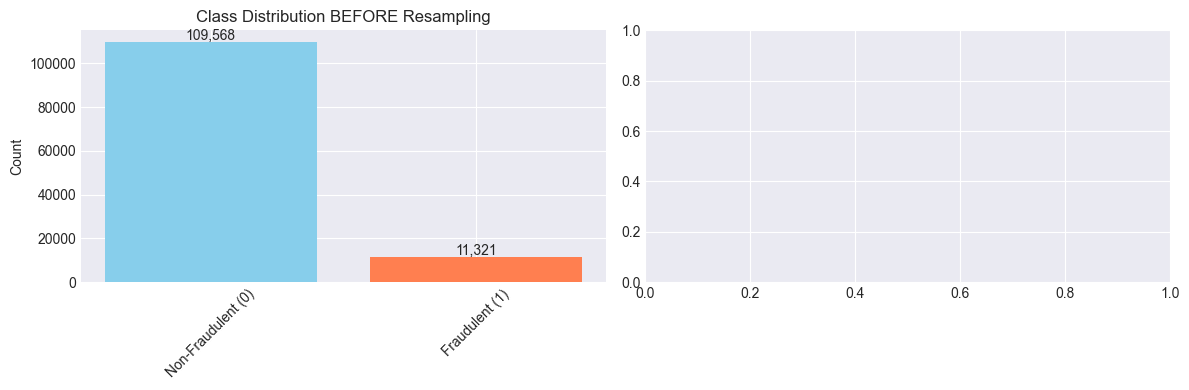

In [39]:
# Document class distribution BEFORE resampling
print("Class Distribution BEFORE Resampling:")
print(f"Training set:")
print(f"  Non-fraudulent (0): {(y_train_fraud == 0).sum():,} ({(y_train_fraud == 0).mean()*100:.2f}%)")
print(f"  Fraudulent (1): {(y_train_fraud == 1).sum():,} ({(y_train_fraud == 1).mean()*100:.2f}%)")
print(f"  Imbalance Ratio: {(y_train_fraud == 0).sum() / (y_train_fraud == 1).sum():.2f}:1")

# Visualize before resampling
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

before_counts = y_train_fraud.value_counts()
axes[0].bar(['Non-Fraudulent (0)', 'Fraudulent (1)'], before_counts.values, color=['skyblue', 'coral'])
axes[0].set_title('Class Distribution BEFORE Resampling')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

axes[0].text(0, before_counts[0], f'{before_counts[0]:,}', ha='center', va='bottom')
axes[0].text(1, before_counts[1], f'{before_counts[1]:,}', ha='center', va='bottom')

plt.tight_layout()
save_plot(fig, 'fraud_smote_before_after_comparison.png')
plt.show()



Applying SMOTE...

Class Distribution AFTER SMOTE:
Training set:
  Non-fraudulent (0): 109,568 (66.67%)
  Fraudulent (1): 54,784 (33.33%)
  New Ratio: 2.00:1
Plot saved to: outputs\eda\feature-engineering\fraud_smote_before_after_comparison.png


<Figure size 640x480 with 0 Axes>

Plot saved to: outputs\eda\feature-engineering\fraud_post_smote_distribution.png


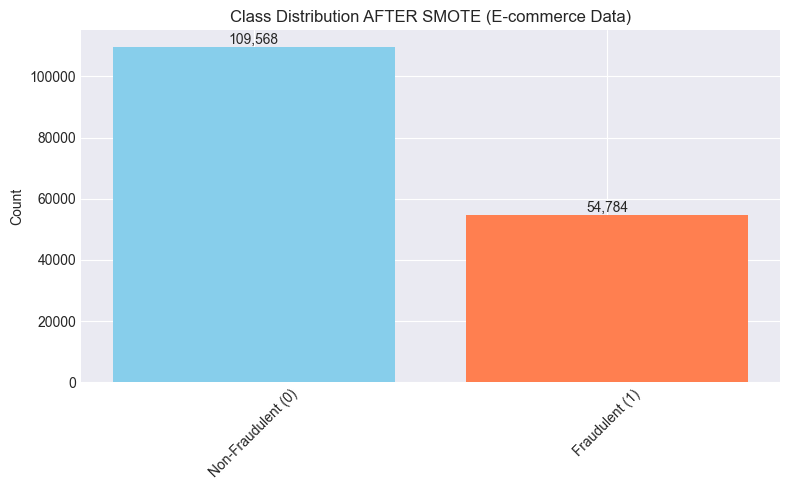


Training set shape after SMOTE: (164352, 19)


In [40]:
# Apply SMOTE to balance the classes
# SMOTE creates synthetic samples of the minority class
print("\nApplying SMOTE...")

smote_fraud = SMOTE(random_state=42, sampling_strategy=0.5)  # Balance to 50% minority class
X_train_fraud_balanced, y_train_fraud_balanced = smote_fraud.fit_resample(X_train_fraud_final, y_train_fraud)

print(f"\nClass Distribution AFTER SMOTE:")
print(f"Training set:")
print(f"  Non-fraudulent (0): {(y_train_fraud_balanced == 0).sum():,} ({(y_train_fraud_balanced == 0).mean()*100:.2f}%)")
print(f"  Fraudulent (1): {(y_train_fraud_balanced == 1).sum():,} ({(y_train_fraud_balanced == 1).mean()*100:.2f}%)")
print(f"  New Ratio: {(y_train_fraud_balanced == 0).sum() / (y_train_fraud_balanced == 1).sum():.2f}:1")

# Visualize after resampling
after_counts = pd.Series(y_train_fraud_balanced).value_counts()
axes[1].bar(['Non-Fraudulent (0)', 'Fraudulent (1)'], after_counts.values, color=['skyblue', 'coral'])
axes[1].set_title('Class Distribution AFTER SMOTE')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

axes[1].text(0, after_counts[0], f'{after_counts[0]:,}', ha='center', va='bottom')
axes[1].text(1, after_counts[1], f'{after_counts[1]:,}', ha='center', va='bottom')

plt.tight_layout()
save_plot(fig, 'fraud_smote_before_after_comparison.png')
plt.show()

# Create a separate post-SMOTE only visualization
fig_post, ax_post = plt.subplots(figsize=(8, 5))
after_counts = pd.Series(y_train_fraud_balanced).value_counts()
ax_post.bar(['Non-Fraudulent (0)', 'Fraudulent (1)'], after_counts.values, color=['skyblue', 'coral'])
ax_post.set_title('Class Distribution AFTER SMOTE (E-commerce Data)')
ax_post.set_ylabel('Count')
ax_post.tick_params(axis='x', rotation=45)
ax_post.text(0, after_counts[0], f'{after_counts[0]:,}', ha='center', va='bottom')
ax_post.text(1, after_counts[1], f'{after_counts[1]:,}', ha='center', va='bottom')
plt.tight_layout()
save_plot(fig_post, 'fraud_post_smote_distribution.png')
plt.show()

print(f"\nTraining set shape after SMOTE: {X_train_fraud_balanced.shape}")


Using existing balanced data from current session
Plot saved to: outputs\eda\feature-engineering\fraud_post_smote_distribution.png


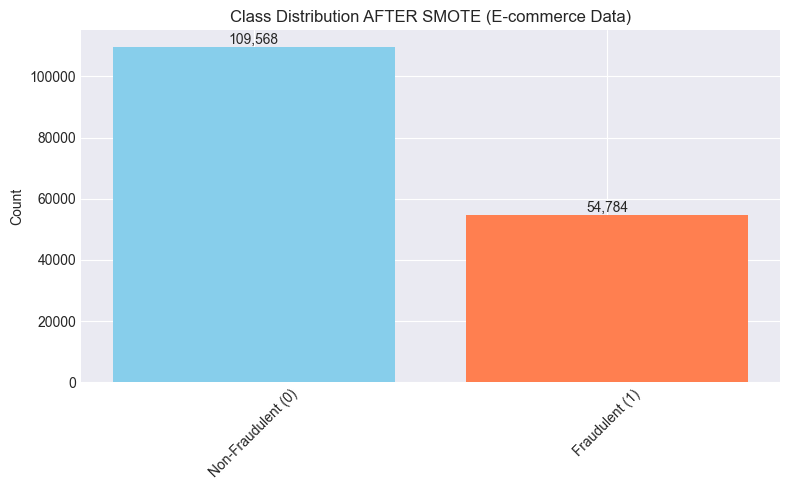

✓ Post-SMOTE visualization saved!


In [41]:
# Quick check: If SMOTE is taking too long, you can generate the visualization separately
# This cell can be run independently after SMOTE completes

# Check if balanced data exists (from previous run)
try:
    # Try to load already processed data if SMOTE was run before
    if 'y_train_fraud_balanced' in locals():
        print("Using existing balanced data from current session")
        after_counts = pd.Series(y_train_fraud_balanced).value_counts()
        
        # Create post-SMOTE visualization
        fig_post, ax_post = plt.subplots(figsize=(8, 5))
        ax_post.bar(['Non-Fraudulent (0)', 'Fraudulent (1)'], after_counts.values, color=['skyblue', 'coral'])
        ax_post.set_title('Class Distribution AFTER SMOTE (E-commerce Data)')
        ax_post.set_ylabel('Count')
        ax_post.tick_params(axis='x', rotation=45)
        ax_post.text(0, after_counts[0], f'{after_counts[0]:,}', ha='center', va='bottom')
        ax_post.text(1, after_counts[1], f'{after_counts[1]:,}', ha='center', va='bottom')
        plt.tight_layout()
        save_plot(fig_post, 'fraud_post_smote_distribution.png')
        plt.show()
        print("✓ Post-SMOTE visualization saved!")
    else:
        print("⚠ Balanced data not found. Please run the SMOTE cell first (Cell 19).")
except Exception as e:
    print(f"Error: {e}")
    print("Please ensure SMOTE has completed running.")


In [42]:
# Save processed e-commerce data
X_train_fraud_balanced_df = pd.DataFrame(X_train_fraud_balanced, columns=X_train_fraud_final.columns)
X_test_fraud_final_df = X_test_fraud_final.copy()

# Save to processed folder
X_train_fraud_balanced_df.to_csv(PROCESSED_DIR / 'fraud_train_features.csv', index=False)
y_train_fraud_balanced_df = pd.DataFrame(y_train_fraud_balanced, columns=['class'])
y_train_fraud_balanced_df.to_csv(PROCESSED_DIR / 'fraud_train_target.csv', index=False)

X_test_fraud_final_df.to_csv(PROCESSED_DIR / 'fraud_test_features.csv', index=False)
y_test_fraud_df = pd.DataFrame(y_test_fraud, columns=['class'])
y_test_fraud_df.to_csv(PROCESSED_DIR / 'fraud_test_target.csv', index=False)

print("E-commerce fraud data saved to processed folder")


E-commerce fraud data saved to processed folder


## Part 2: Credit Card Fraud Data Feature Engineering


In [43]:
# Load credit card data
cc_df = pd.read_csv(DATA_DIR / 'creditcard.csv')

print(f"Credit Card Data Shape: {cc_df.shape}")
print(f"Columns: {cc_df.columns.tolist()}")
cc_df.head()


Credit Card Data Shape: (284807, 31)
Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 2.1 Data Transformation for Credit Card Data


In [44]:
# Credit card data already has PCA features, so we mainly need to scale
# Separate features and target
X_cc = cc_df.drop('Class', axis=1)
y_cc = cc_df['Class']

# Split into train and test sets
X_train_cc, X_test_cc, y_train_cc, y_test_cc = train_test_split(
    X_cc, y_cc, test_size=0.2, random_state=42, stratify=y_cc
)

print(f"Training set shape: {X_train_cc.shape}")
print(f"Test set shape: {X_test_cc.shape}")
print(f"\nTraining class distribution:")
print(y_train_cc.value_counts())
print(f"\nTest class distribution:")
print(y_test_cc.value_counts())


Training set shape: (227845, 30)
Test set shape: (56962, 30)

Training class distribution:
Class
0    227451
1       394
Name: count, dtype: int64

Test class distribution:
Class
0    56864
1       98
Name: count, dtype: int64


In [45]:
# Scale features (PCA features are already normalized, but Time and Amount need scaling)
scaler_cc = StandardScaler()

# Fit and transform training data
X_train_cc_scaled = pd.DataFrame(
    scaler_cc.fit_transform(X_train_cc),
    columns=X_train_cc.columns,
    index=X_train_cc.index
)

# Transform test data
X_test_cc_scaled = pd.DataFrame(
    scaler_cc.transform(X_test_cc),
    columns=X_test_cc.columns,
    index=X_test_cc.index
)

print("Credit card features scaled")
print("\nScaled training data sample:")
print(X_train_cc_scaled.head())


Credit card features scaled

Scaled training data sample:
            Time        V1        V2        V3        V4        V5        V6  \
265518  1.411588  0.993379 -0.456037 -0.894052 -0.467284  1.089217  3.024383   
180305  0.623141  1.038507 -0.029349 -2.018302  0.175133  2.133506  2.478840   
42664  -1.130680 -0.506766  0.366065  0.470114 -0.700918 -0.598748  1.470411   
198723  0.794699  1.166419 -0.909447 -0.493095 -1.178149 -1.010692 -0.262292   
82325  -0.748102 -0.229485 -0.613041  0.076742 -2.440089  0.518711 -0.109914   

              V7        V8        V9  ...       V20       V21       V22  \
265518 -1.194852  0.957057  1.281376  ... -0.173112  0.103171  0.409563   
180305 -0.001832  0.566704  0.041121  ... -0.293564  0.052055  0.314019   
42664  -1.786684 -4.227592  0.000064  ...  1.663010 -3.807987  0.150500   
198723 -1.153123  0.008765 -1.019866  ... -0.635236 -0.190540  0.105701   
82325   0.407186 -0.095161 -0.041449  ... -0.355860 -0.331467 -0.239208   

          

### 2.2 Handle Class Imbalance for Credit Card Data


Class Distribution BEFORE Resampling:
Training set:
  Non-fraudulent (0): 227,451 (99.8271%)
  Fraudulent (1): 394 (0.1729%)
  Imbalance Ratio: 577.29:1


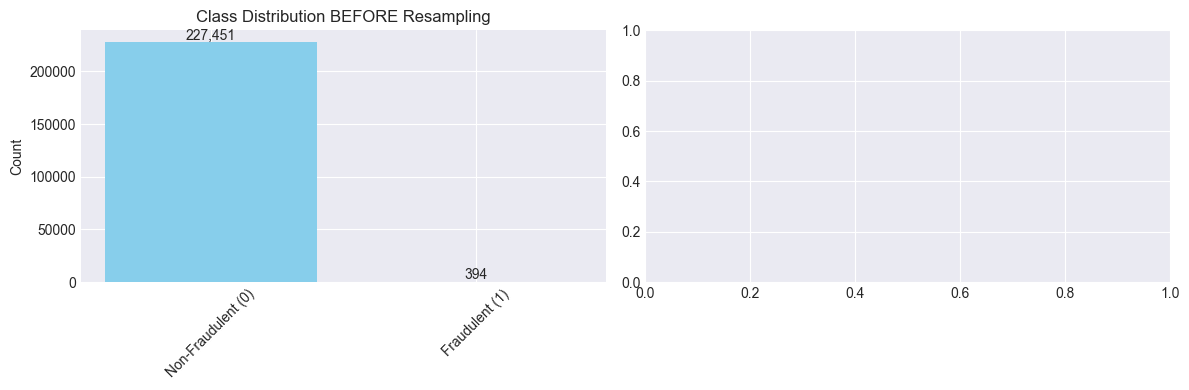

In [46]:
# Document class distribution BEFORE resampling
print("Class Distribution BEFORE Resampling:")
print(f"Training set:")
print(f"  Non-fraudulent (0): {(y_train_cc == 0).sum():,} ({(y_train_cc == 0).mean()*100:.4f}%)")
print(f"  Fraudulent (1): {(y_train_cc == 1).sum():,} ({(y_train_cc == 1).mean()*100:.4f}%)")
print(f"  Imbalance Ratio: {(y_train_cc == 0).sum() / (y_train_cc == 1).sum():.2f}:1")

# Visualize before resampling
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

before_counts_cc = y_train_cc.value_counts()
axes[0].bar(['Non-Fraudulent (0)', 'Fraudulent (1)'], before_counts_cc.values, color=['skyblue', 'coral'])
axes[0].set_title('Class Distribution BEFORE Resampling')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

axes[0].text(0, before_counts_cc[0], f'{before_counts_cc[0]:,}', ha='center', va='bottom')
axes[0].text(1, before_counts_cc[1], f'{before_counts_cc[1]:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


Using existing balanced data from current session
Plot saved to: outputs\eda\feature-engineering\creditcard_post_smote_distribution.png


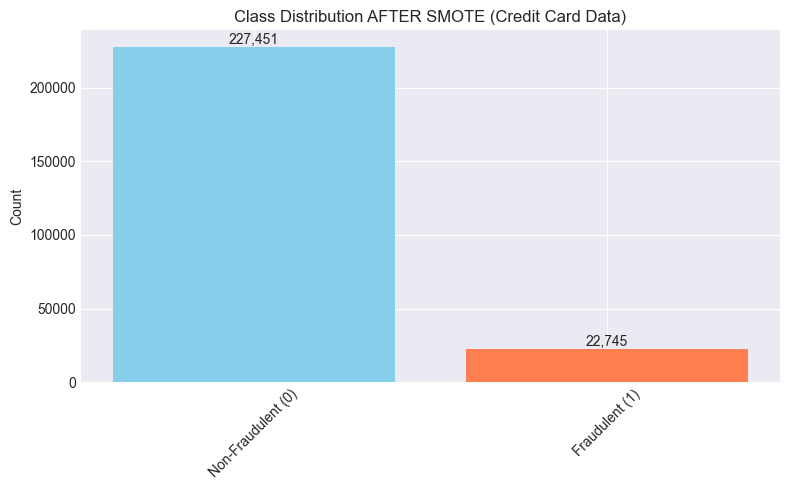

✓ Post-SMOTE visualization saved!


In [47]:
# Quick check: If SMOTE is taking too long, you can generate the visualization separately
# This cell can be run independently after SMOTE completes

# Check if balanced data exists (from previous run)
try:
    # Try to load already processed data if SMOTE was run before
    if 'y_train_cc_balanced' in locals():
        print("Using existing balanced data from current session")
        after_counts_cc = pd.Series(y_train_cc_balanced).value_counts()
        
        # Create post-SMOTE visualization
        fig_post_cc, ax_post_cc = plt.subplots(figsize=(8, 5))
        ax_post_cc.bar(['Non-Fraudulent (0)', 'Fraudulent (1)'], after_counts_cc.values, color=['skyblue', 'coral'])
        ax_post_cc.set_title('Class Distribution AFTER SMOTE (Credit Card Data)')
        ax_post_cc.set_ylabel('Count')
        ax_post_cc.tick_params(axis='x', rotation=45)
        ax_post_cc.text(0, after_counts_cc[0], f'{after_counts_cc[0]:,}', ha='center', va='bottom')
        ax_post_cc.text(1, after_counts_cc[1], f'{after_counts_cc[1]:,}', ha='center', va='bottom')
        plt.tight_layout()
        save_plot(fig_post_cc, 'creditcard_post_smote_distribution.png')
        plt.show()
        print("✓ Post-SMOTE visualization saved!")
    else:
        print("⚠ Balanced data not found. Please run the SMOTE cell first (Cell 28).")
except Exception as e:
    print(f"Error: {e}")
    print("Please ensure SMOTE has completed running.")



Applying SMOTE...

Class Distribution AFTER SMOTE:
Training set:
  Non-fraudulent (0): 227,451 (90.91%)
  Fraudulent (1): 22,745 (9.09%)
  New Ratio: 10.00:1
Plot saved to: outputs\eda\feature-engineering\creditcard_smote_before_after_comparison.png


<Figure size 640x480 with 0 Axes>

Plot saved to: outputs\eda\feature-engineering\creditcard_post_smote_distribution.png


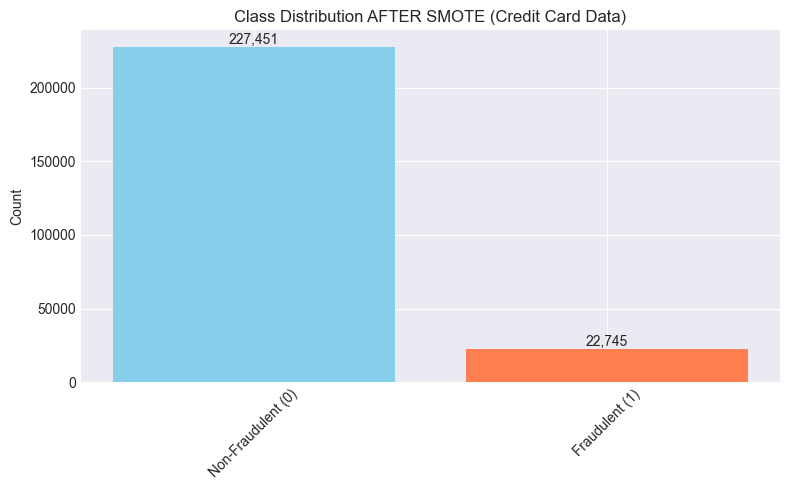


Training set shape after SMOTE: (250196, 30)


In [48]:
# Apply SMOTE for credit card data
# Note: For extremely imbalanced data, we might use a lower sampling_strategy
print("\nApplying SMOTE...")

smote_cc = SMOTE(random_state=42, sampling_strategy=0.1)  # Balance to 10% minority class (less aggressive)
X_train_cc_balanced, y_train_cc_balanced = smote_cc.fit_resample(X_train_cc_scaled, y_train_cc)

print(f"\nClass Distribution AFTER SMOTE:")
print(f"Training set:")
print(f"  Non-fraudulent (0): {(y_train_cc_balanced == 0).sum():,} ({(y_train_cc_balanced == 0).mean()*100:.2f}%)")
print(f"  Fraudulent (1): {(y_train_cc_balanced == 1).sum():,} ({(y_train_cc_balanced == 1).mean()*100:.2f}%)")
print(f"  New Ratio: {(y_train_cc_balanced == 0).sum() / (y_train_cc_balanced == 1).sum():.2f}:1")

# Visualize after resampling
after_counts_cc = pd.Series(y_train_cc_balanced).value_counts()
axes[1].bar(['Non-Fraudulent (0)', 'Fraudulent (1)'], after_counts_cc.values, color=['skyblue', 'coral'])
axes[1].set_title('Class Distribution AFTER SMOTE')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

axes[1].text(0, after_counts_cc[0], f'{after_counts_cc[0]:,}', ha='center', va='bottom')
axes[1].text(1, after_counts_cc[1], f'{after_counts_cc[1]:,}', ha='center', va='bottom')

plt.tight_layout()
save_plot(fig, 'creditcard_smote_before_after_comparison.png')
plt.show()

# Create a separate post-SMOTE only visualization
fig_post_cc, ax_post_cc = plt.subplots(figsize=(8, 5))
after_counts_cc = pd.Series(y_train_cc_balanced).value_counts()
ax_post_cc.bar(['Non-Fraudulent (0)', 'Fraudulent (1)'], after_counts_cc.values, color=['skyblue', 'coral'])
ax_post_cc.set_title('Class Distribution AFTER SMOTE (Credit Card Data)')
ax_post_cc.set_ylabel('Count')
ax_post_cc.tick_params(axis='x', rotation=45)
ax_post_cc.text(0, after_counts_cc[0], f'{after_counts_cc[0]:,}', ha='center', va='bottom')
ax_post_cc.text(1, after_counts_cc[1], f'{after_counts_cc[1]:,}', ha='center', va='bottom')
plt.tight_layout()
save_plot(fig_post_cc, 'creditcard_post_smote_distribution.png')
plt.show()

print(f"\nTraining set shape after SMOTE: {X_train_cc_balanced.shape}")


In [49]:
# Save processed credit card data
X_train_cc_balanced_df = pd.DataFrame(X_train_cc_balanced, columns=X_train_cc_scaled.columns)
X_test_cc_scaled_df = X_test_cc_scaled.copy()

# Save to processed folder
X_train_cc_balanced_df.to_csv(PROCESSED_DIR / 'creditcard_train_features.csv', index=False)
y_train_cc_balanced_df = pd.DataFrame(y_train_cc_balanced, columns=['Class'])
y_train_cc_balanced_df.to_csv(PROCESSED_DIR / 'creditcard_train_target.csv', index=False)

X_test_cc_scaled_df.to_csv(PROCESSED_DIR / 'creditcard_test_features.csv', index=False)
y_test_cc_df = pd.DataFrame(y_test_cc, columns=['Class'])
y_test_cc_df.to_csv(PROCESSED_DIR / 'creditcard_test_target.csv', index=False)

print("Credit card data saved to processed folder")


Credit card data saved to processed folder


## Summary

### E-commerce Fraud Data:
1. **Features Created:**
   - Time-based: hour_of_day, day_of_week, time_since_signup
   - Transaction frequency: total_transactions, transactions_last_24h/7d/30d
   - Transaction velocity: velocity_last_24h
   - Purchase patterns: avg_purchase_value, purchase_value_deviation
   - Geolocation: country, country_fraud_rate

2. **Data Transformation:**
   - Numerical features: StandardScaler
   - Categorical features: One-Hot Encoding

3. **Class Imbalance Handling:**
   - Method: SMOTE (sampling_strategy=0.5)
   - Before: [Document ratio]
   - After: [Document ratio]

### Credit Card Fraud Data:
1. **Data Transformation:**
   - All features scaled using StandardScaler

2. **Class Imbalance Handling:**
   - Method: SMOTE (sampling_strategy=0.1)
   - Before: [Document ratio]
   - After: [Document ratio]

### Next Steps:
- Model training and evaluation
- Model selection and comparison
- Model explainability analysis
